# Séries Temporelles :

## Sommaire :

* [**1.Introduction**](#0)

* [**2.Tendance**](#1)
    * [2.1. Méthode par régréssion](#1.1)
    * [2.2. Méthode par moyenne mobile](#1.2)
    
* [**3.Saisonnalité**](#2)
    * [3.1 Méthodes par régression](#2.1)
        * [A. Buys Ballot](#2.1.1)
        * [B. STL (Seasonal decomposition of Time series)](#2.1.2)
    * [3.2 Méthodes par moyenne mobile ](#2.2)
    * [3.3 Méthodes Transformée de Fourier, FTT (fast fourier transform) et machine learning](#2.3)
* [**4. Test de Stationnarité : Test de Dickey-Fuller**](#3)
* [**5. Modèle ARMA**](#4)
    * [5.1 Caractéristiques ARMA](#4.1)
    * [5.2 Estimation des coefficients : Méthode statistique](#4.2)
        - [A. Equations Yule-Walker](#4.2.1)
        - [B. Vraisemblance](#4.2.2)
        - [C. Critères de Akaïque et Schwarz](#4.2.3)
* [**6. Modèle ARIMA**](#5)
    * [6.1 Estimation avec machine learning](#5.1)
* [**7. Forecasting**](#6)
    * [7.1 Backtest ARIMA : ML](#6.1)
    * [7.1 Backtest AR : Box et Jenkins](#6.2)
    * [7.1 Comparaison des résultats](#6.3)

<a id='0'></a>
## 1. Introduction :

Définition : Une série temporelle (ou encore une série chronologique) est une suite finie $(x_1, · · · , x_n)$ de données indexées par le temps.

Objectif de l'étude de séries temporelles :
* Trouver les composantes de la série (saisonnalité, bruit, tendance) pour en déduire des propriétés 
* Prévoir : établir des modèles de prédictions 
* Détection de rupture : Déterminer les instants où les paramètres de la série se modifient

### Définition des caractéristiques importantes : 

* Stationarité : Une série $(Xt)$ est stationnaire si ses propriétés probabilistes sont les mêmes que celles de la série $(Xt+h)$, pour tout entier h.

Les bruits sont en général considéré comme stationnaire.
Rendre un processus stationnaire peut être intéressant pour plusieurs raison mais notamment pour obtenir une espérance et une covariance constantes.

Une idée naturelle est de rechercher d’abord, au vu des données, la meilleure fonction déterministe dt telle que le résidu $X_t − d_t$ soit raisonnablement stationnaire.
C'est l'idée qui est reprise dans l'algorithme de Box et Jenkins qui va être abordée dans ce projet.

#### Premier Modèle : 

$$X_t = M_t + S_t + Z_t$$

* $M_t$ : Tendance, fonction qui varie lentement
* $S_t$ : Saisonnalité (périodique)
* $Z_t$ : Partie aléatoire, Bruit

#### Exemple : S&P 500

Pour chaque application numérique dans ce projet, nous allons prendre et utiliser l'exemple du S&P500, un des indices boursier américain.

In [56]:
import numpy as np
import requests  # Connexion à l'API de AlphaVantage
import matplotlib.pyplot as plt
from scipy.optimize import minimize

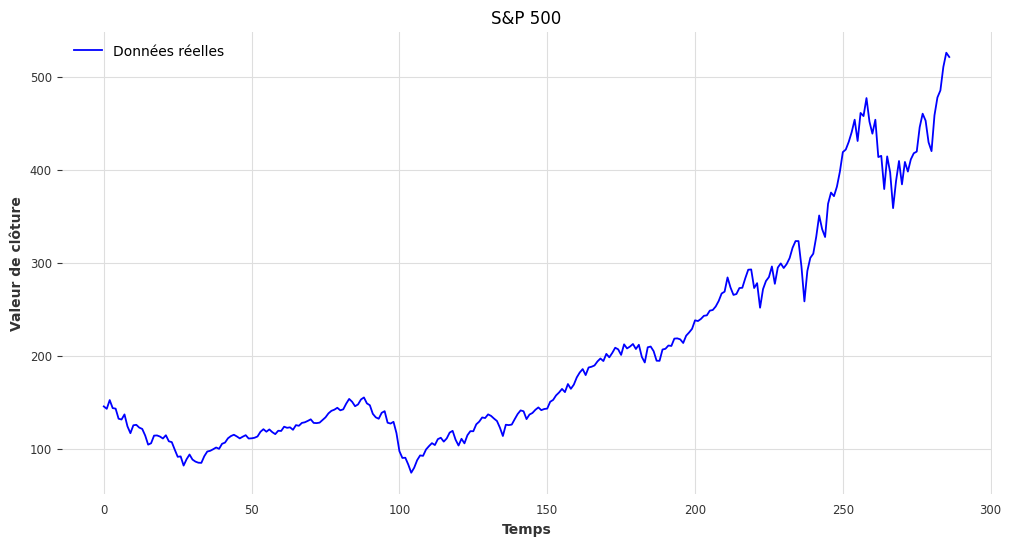

In [57]:
# Exemple S&P 500
symbol = 'IVV'

# Clé personelle Alpha Vantage
key_API = 'LYMJQ6KR5QPKJ8W3'

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol={symbol}&apikey={key_API}'
r = requests.get(url)
data_json = r.json()

# Accès au sous-dictionnaire contenant les données
time_series = data_json['Monthly Adjusted Time Series']

# Extraction des données de clôture (4. close) en tant que tableau NumPy
closing_prices = np.array([float(entry['4. close']) for entry in time_series.values()])

# Ordre temporaire 
closing_prices = closing_prices[::-1]

abscisse = [i for i in range(len(closing_prices))]

# Data visualisation
plt.figure(figsize=(12, 6))
plt.plot(abscisse, closing_prices, label='Données réelles', color='blue')
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.title('S&P 500')
plt.legend()
plt.show()

<a id='1'></a>
## 2. Tendance / Trend ($M_t$):

<a id='1.1'></a>
### 2.1 Méthode par régression :

**Guys Ballot :** La méthode de Buys-Ballot généralisée consiste à spécifier les composantes déterministes (trend et saison) comme une combinaison linaire de fonctions connues du temps, puis à effectuer une régression linéaire ordinaire.


Le modèle le plus populaire pour estimer une tendance est le modèle de tendance polynomiale : 

$$M_t = a_0 + a_1t + ... + a_dt^d$$

Dans ce modèle : 
* On repère une approximation de d par data visualisation
* On peut estimer le vecteur a par la méthode des moindres carrés.

$$â = \text{arg min}_a \sum_{t=1}^{n} (x_t - m_t)^2$$

D'après le théorème de Gauss-Markov sur les modèle linéaire : 

En posant la matrice (De Vandermonde dans ce cas):

$$A = \begin{bmatrix}
1 & t_1 & t_1^2 & \ldots & t_1^d \\
1 & t_2 & t_2^2 & \ldots & t_2^d \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & t_n & t_n^2 & \ldots & t_n^d
\end{bmatrix}, X = \begin{pmatrix} x_1 \\ \vdots \\ x_n \end{pmatrix}, a = \begin{pmatrix} a_1 \\ \vdots \\ a_d \end{pmatrix}$$

On obtient :

$$â = (A^TA)^{-1}A^TX$$


In [58]:
# Implémentation de l'algo

def tendance(d, X):
    # Création de A
    A = np.array([[k**i for i in range(d+1)] for k in range(len(X))])

    # Calcul des coefficients
    B = np.dot(A.T, A)
    B_inverse = np.linalg.inv(B)
    C = np.dot(A.T, X)
    result = np.dot(B_inverse, C)
    
    return result

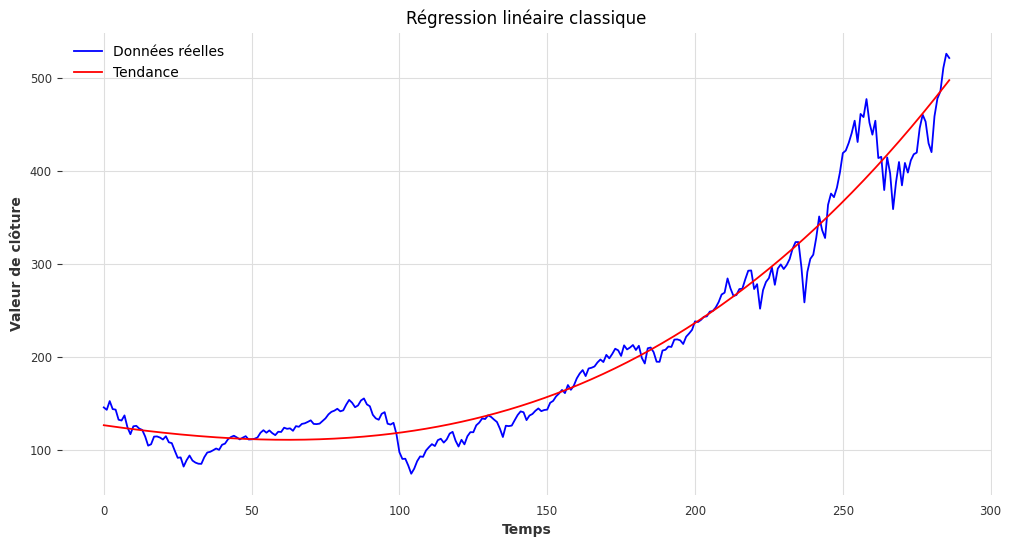

In [59]:
# Détermination tendance
a = tendance(3, closing_prices)

def f_tendance(t):
    return(a[0] + a[1] * t + a[2] * (t ** 2) + a[3] * (t ** 3))

abscisse = [i for i in range(len(closing_prices))]

# Data visualisation
plt.figure(figsize=(12, 6))
plt.plot(abscisse, closing_prices, label='Données réelles', color='blue')
plt.plot(f_tendance(np.array(abscisse)), label='Tendance', color='red')
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.legend()
plt.title('Régression linéaire classique')
plt.show()

Conclusion : L'algorithme fonctionne 

<a id='1.2'></a>
### 2.2 Méthode Moyenne mobile :

**Défintion :** La moyenne mobile d’ordre m1 + m2 + 1 est définie par :

$$MX_t = \theta _{-m_1}X_{t-m_1} + \theta _{-m_1+1}X_{t-m_1+1} + \ldots + \theta _{m_2}X_{t+m_2}$$

Remarque : 

* Pour $T$ observations, on a : $m_1 < t < T-m_2$
* La moyenne mobile est dite symétrique si $m_1 = m_2$
* La contrainte $\sum_{j=-m_1}^{m-2}\theta_j = 1$ permet de garder les constantes, si en plus symétrique la MM conserve également les polynômes de degré 1



**Moyenne mobile arithmétique :**

La MM symétrique qui conserve la contrainte $\sum_{j=-m}^{m}\theta_j = 1$ qui a le plus grand pouvoir de réduction de la variance du bruit est la MM arithmétique :

**$$\theta_j = \frac{1}{2m+1}$$**

Elle s'obtient grâce à l'optimisation suivante :
$\min_{\theta} \sum_{j=-m}^{m} \theta_j^2$ avec la contrainte $\sum_{j=-m}^{m} \theta_j = 1$


Propriétés :
* Elle annule les périodes de saison $2m+1$ 
* Elle conserve les polynômes de degré 1

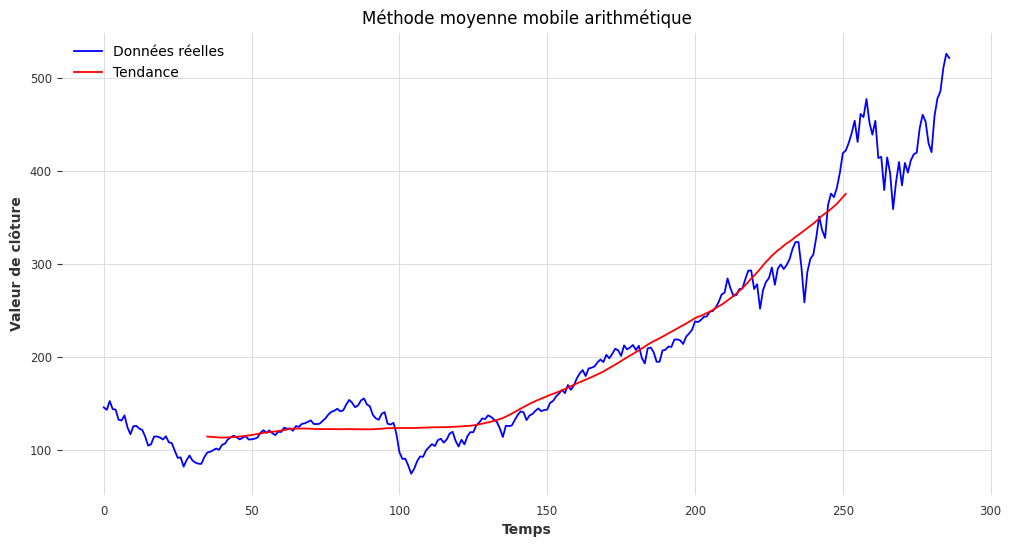

In [60]:
# Implémentation de l'algo
# Valeur de notre p = 2m + 1

p = 71  # Doit être impair
m = 0.5 * (p - 1)
theta = 1 / p  # Valeur de mes thetas (constants)
X_sym = []

for k in range(int(m), int(len(closing_prices) - m)):
    s = 0
    for j in range(p):
        s += theta * closing_prices[int(j + k - m)]
    X_sym.append(s)

# Visualisation
abscisse = [i for i in range(len(closing_prices))]
abscisse_filter = [i for i in range(int(m), len(closing_prices) - int(m))]

# Data visualisation
plt.figure(figsize=(12, 6))
plt.plot(abscisse, closing_prices, label='Données réelles', color='blue')
plt.plot(abscisse_filter, X_sym, label='Tendance', color='red')
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.title('Méthode moyenne mobile arithmétique')
plt.legend()
plt.show()

<a id='2'></a>
## 3. Saisonnalité ($S_t$):

<a id='2.1'></a>
### 3.1 Méthodes par régression :

#### A. Buys Ballot :

**Guys Ballot :** La méthode de Buys-Ballot généralisée consiste à spécifier les composantes déterministes (trend et saison) comme une combinaison linaire de fonctions connues du temps, puis à effectuer une régression linéaire ordinaire.

Le modèle le plus populaire pour estimer la saisonnalité est le modèle trigonométrique suivant:

$$s_t = a_0 + \sum_{j=1}^{k} (a_jcos(\lambda_jt) + b_jsin(\lambda_jt))$$

Dans ce modèle : 
* On va supposer $\lambda$ constant et égal à $2\pi/d$, avec $d$ à déterminer par visualisation graphique.

* On peut estimer le vecteur a par la méthode des moindres carrés (Si $\lambda$ constant, alors $a$ est de dimension 3)

$$â = \text{arg min}_a \sum_{t=1}^{n} (x_t - m_t)^2$$

D'après nos cours de modèles linéaires généralisés : 

En posant:

$$A = \begin{bmatrix}
1 & cos(\lambda t_1) & sin(\lambda t_1) \\
1 & cos(\lambda t_2) & sin(\lambda t_2) \\
\vdots & \vdots & \vdots  \\
1 & cos(\lambda t_n) & sin(\lambda t_n)
\end{bmatrix}, X = \begin{pmatrix} x_1 \\ \vdots \\ x_n \end{pmatrix}, a = \begin{pmatrix} a_0 \\ a_1 \\ b_1 \end{pmatrix}$$

On obtient :

$$â = (A^TA)^{-1}A^TX$$

In [61]:
# Implémentation de l'algo

def saison(d, X):
    X_saison = [X[k] - f_tendance(k) for k in range (len(X))]
    l = (2 * np.pi)/d
    # Création de A
    A = np.array([[1, np.cos(l*X_saison[k]), np.sin(l*X_saison[k])] for k in range(len(X))])

    # Calcul des coefficients
    B = np.dot(A.T, A)
    B_inverse = np.linalg.inv(B)
    C = np.dot(A.T, X_saison)
    result = np.dot(B_inverse, C)
    
    return result

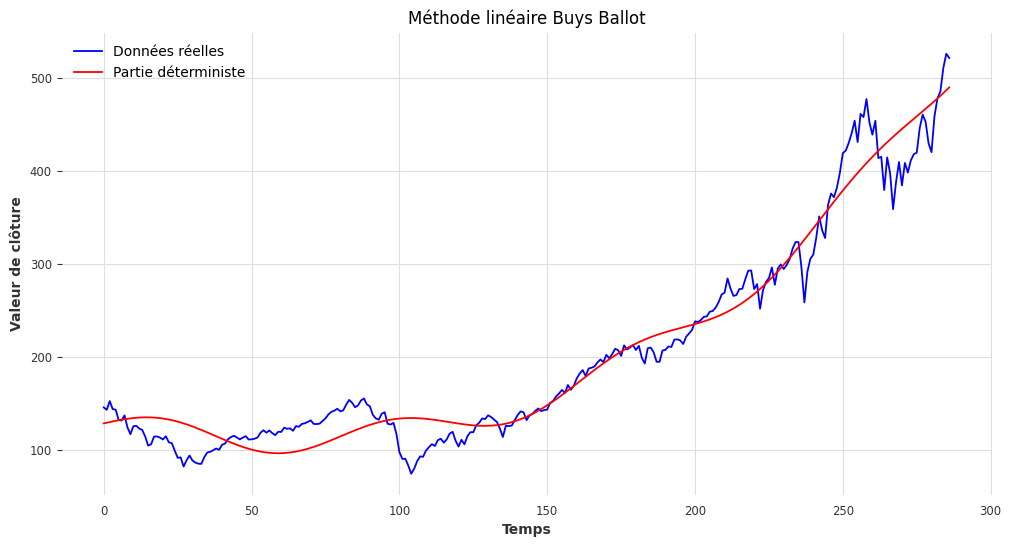

In [62]:
# Vérification graphique 
# D'après le graphique au dessus, en évaluant la période on a d = 80 (regarde quand la courbe rouge passe au dessous de la bleu)
d = 80

s = saison(d, closing_prices)

def f_saison(t):
    return(s[0] + s[1] * np.cos(t * (2 * np.pi)/d) + s[2] * np.sin(t * (2 * np.pi)/d))

def partie_derterministe(t):
    return(f_tendance(t) + f_saison(t))

abscisse = [i for i in range(len(closing_prices))]

# Data visualisation
plt.figure(figsize=(12, 6))
plt.plot(abscisse, closing_prices, label='Données réelles', color='blue')
plt.plot(partie_derterministe(np.array(abscisse)), label='Partie déterministe', color='red')  # Utilisez np.array(abscisse) pour la fonction poly
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.title('Méthode linéaire Buys Ballot')
plt.legend()
plt.show()

Remarque : Légère asymétrie autour de 80 mois, principalement liée à cause des $\lambda$ constants, la période est pas réellement constante.
Pour cette raison, la méthode STL semble fortement pertinente.

#### B. STL (Seasonal decomposition of Time Series) :

**STL** : La méthode STL (Seasonal decomposition of Time series by Loess) consiste à spécifier les composantes déterministes comme une combinaison linaire de fonctions simples et connues du temps, puis à effectuer localement des régressions linéaires ordinaires. (On applique Buys Ballot sur une discrétisation de la série)

Nous allons donc utiliser le même modèle :
$$s_t = a_0 + \sum_{j=1}^{k} (a_jcos(\lambda_jt) + b_jsin(\lambda_jt))$$

Dans ce modèle : 
* On va supposer $\lambda$ constant et égal à $2\pi/d$, avec $d$ à déterminer par visualisation graphique.

* On peut estimer le vecteur a par la méthode des moindres carrés (Si $\lambda$ constant, alors $a$ est de dimension 3)

$$â = \text{arg min}_a \sum_{t=1}^{n} (x_t - m_t)^2$$

D'après nos cours de modèles linéaires généralisés : 

En posant:

$$A = \begin{bmatrix}
1 & cos(\lambda t_1) & sin(\lambda t_1) \\
1 & cos(\lambda t_2) & sin(\lambda t_2) \\
\vdots & \vdots & \vdots  \\
1 & cos(\lambda t_n) & sin(\lambda t_n)
\end{bmatrix}, X = \begin{pmatrix} x_1 \\ \vdots \\ x_n \end{pmatrix}, a = \begin{pmatrix} a_0 \\ a_1 \\ b_1 \end{pmatrix}$$

On obtient :

$$â = (A^TA)^{-1}A^TX$$

In [63]:
# Implémentation de l'algo
def saison_stl (d, X):
    a = tendance(3, X)

    def f_tendance(t):
        return(a[0] + a[1] * t + a[2] * (t ** 2) + a[3] * (t ** 3))
    
    X_saison = [X[k] - f_tendance(k) for k in range (len(X))]
    l = (2 * np.pi)/d
    # Création de A
    A = np.array([[1, np.cos(l*X_saison[k]), np.sin(l*X_saison[k])] for k in range(len(X))])

    # Calcul des coefficients
    B = np.dot(A.T, A)
    B_inverse = np.linalg.inv(B)
    C = np.dot(A.T, X_saison)
    result = np.dot(B_inverse, C)
    
    return result

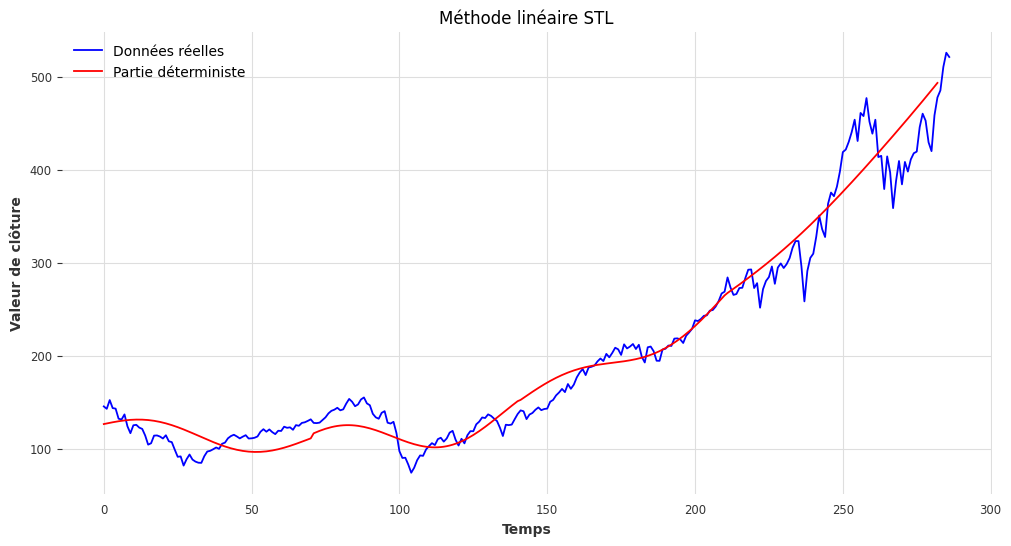

In [65]:
# Vérification graphique 
# D'après le graphique au dessus, en évaluant la période on a d = 70 (regarde quand la courbe rouge passe au dessous de la bleu)
d = 70

# Liste valeurs lissées
X_stl = []
# Tableau avec les coefs de la régression
s_stl = np.array([])

# Calcul des coefs pour chaque segments séparés
for k in range(1, 5):
    segment = saison_stl(d, closing_prices[71 * (k - 1) : 71 * k])
    s_stl = np.concatenate((s_stl, segment))

# Calcul de St + Mt pour chaque segment
for k in range (71):
        X_stl.append(s_stl[0] + s_stl[1] * np.cos(k * (2 * np.pi) / d) + s_stl[2] * np.sin(k * (2 * np.pi) / d) + f_tendance(k))
for k in range (72, 142):
        X_stl.append(s_stl[3] + s_stl[4] * np.cos(k * (2 * np.pi) / d) + s_stl[5] * np.sin(k * (2 * np.pi) / d) + f_tendance(k))
for k in range (143, 213):
        X_stl.append(s_stl[6] + s_stl[7] * np.cos(k * (2 * np.pi) / d) + s_stl[8] * np.sin(k * (2 * np.pi) / d) + f_tendance(k))
for k in range (214, 286):
        X_stl.append(s_stl[9] + s_stl[10] * np.cos(k * (2 * np.pi) / d) + s_stl[11] * np.sin(k * (2 * np.pi) / d) + f_tendance(k))


abscisse_stl = [i for i in range(len(closing_prices) - 4)]
abscisse = [i for i in range(len(closing_prices))]

# Data visualisation
plt.figure(figsize=(12, 6))
plt.plot(abscisse, closing_prices, label='Données réelles', color='blue')
plt.plot(abscisse_stl, X_stl, label='Partie déterministe', color='red')  # Utilisez np.array(abscisse) pour la fonction poly
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.title('Méthode linéaire STL')
plt.legend()
plt.show()

Remarque : Le résultat semble légèrement mieux que pour la méthode de Guys Ballot, cependant il reste quand même très approximatif.

<a id='2.2'></a>
### 3.2 Méthode Moyenne mobile :

**Rappel Défintion :** La moyenne mobile d’ordre m1 + m2 + 1 est définie par :

$$MX_t = \theta _{-m_1}X_{t-m_1} + \theta _{-m_1+1}X_{t-m_1+1} + \ldots + \theta _{m_2}X_{t+m_2}$$


#### **Moyennes mobiles d'Henderson :**

Les coefs $\theta$ se trouvent avec l'optmisation suivante:

$$\min_{\theta} \sum_{i} (\Delta ^3 \theta_i)^2  = \min_{\theta} \sum_{i} (\theta_i - 3\theta_{i-1} +3\theta_{i-2} - \theta_{i-3})^2$$ 

**Moyenne mobile d'Henderson d'ordre $2m-3$ :**

Pour $i \in [-m-1, m+1]$ :
$$\theta_i=\frac{315((m-1)^2-i^2)(m^2-i^2)((m+1)^2-i^2)(m^2-16-11i^2)}{8m(m^2-1)(4m^2-1)(4m^2-9)(4m^2-25)}$$
Propriété :
* Elle conserve les polynômes de degré 1 et 2 (utile pour notre exemple S&P 500)

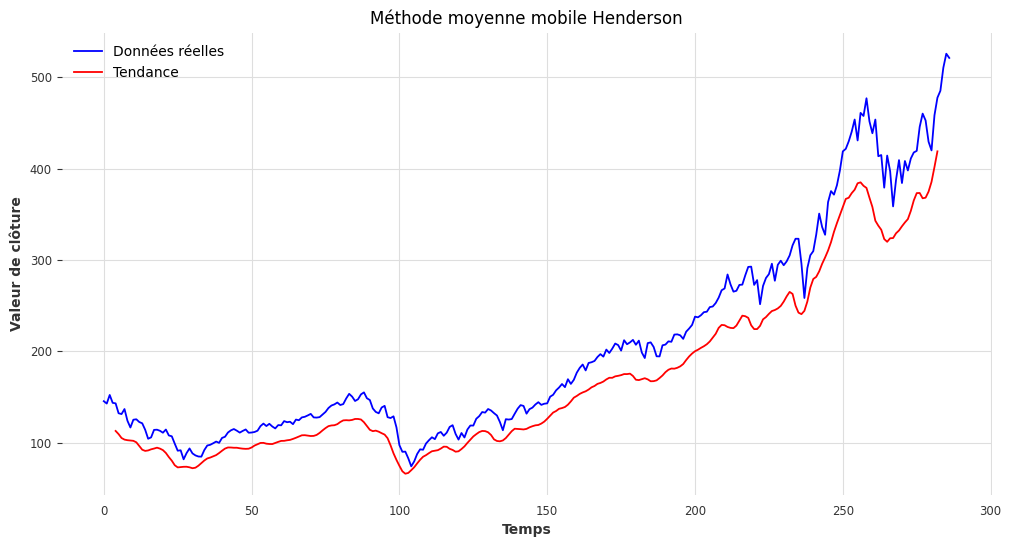

In [66]:
# Filtrage par Moyenne mobile
# Calcul des coefficients 
def theta(i, m):
    numerateur = 315 * ((m - 1)**2 - i**2) * (m**2 - i**2) * ((m + 1)**2 - i**2) * (3 * (m**2) - 16 - 11 * (i**2))
    denominateur = 8 * m * (m**2 - 1) * (4 * (m**2) - 1) * (4 * (m**2) - 9) * (4 * (m**2) - 25)
    return (numerateur/denominateur)

# Application S&P 500
m = 8
theta_SP = [theta(i, m) for i in range(-m+2, m-1)]

# Définition de la série lissée
price_filter = []

for k in range (len(closing_prices) - m):
    s = 0
    for j in range (m):
        s += theta_SP[j] * closing_prices[k + j]
    price_filter.append(s)

# Visualisation
abscisse = [i for i in range(len(closing_prices))]
abscisse_filter = [i for i in range(int(m/2), len(closing_prices) - int(m/2))]

# Data visualisation
plt.figure(figsize=(12, 6))
plt.plot(abscisse, closing_prices, label='Données réelles', color='blue')
plt.plot(abscisse_filter, price_filter, label='Tendance', color='red')
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.title('Méthode moyenne mobile Henderson')
plt.legend()
plt.show()

<a id='2.3'></a>
### 3.3 Transformée de Fourier discrète et FTT (Fast Fourier transform)

En effet, la problématique concernant la détermination de la saisonnalité revient à étudier les signaux périodiques d'une série.

**Résumé :**

L'objectif est d'approcher notre série $S_N(t)$, (ou $N$ représente la longueur de la série) par une fonction complexe :

$$S_N(t)=\sum_{k=0}^{N-1}C_k\exp(\frac{i2\pi kt}{N})$$

Les coefficients $C_k$ se trouvent grâce à la DFT :

**Transformée de Fourier Discrète (DFT):**

$$DFT(f_k)=\sum_{n=0}^{N-1}S_N(n)\exp(-if_kn)$$

On a ensuite la relation :

$$ \| \text{DFT}(f_k) \|^2 = \| \mathcal{C}_k \|^2 $$

Remarque :
$\| \mathcal{C}_k \|^2 $ s'appelle le périodigramme, noté $P(f_k)$.

##### FTT :

Les FTT sont des algorithmes qui calculent les transformés de Fourier discrètes de façon très optimisée, évaluer les $C_k$ en utilisant les racines $n_{ie}$ de l'unité, ce qui permet de réduire considérablement la complexité de calcul.

Certains algorithmes d'apprentissage authomatique utilisent les FTT, on peut en retrouver au sein de la librairie "Darts".

In [67]:
from darts import TimeSeries
from darts.models import FFT

In [68]:
# Données stockage, nb données : 285
data_periodique = [closing_prices[k] - f_tendance(k) for k in range (len(closing_prices))]
data_periodique = np.array(data_periodique)
X_train = TimeSeries.from_values(data_periodique)

In [69]:
model = FFT(nr_freqs_to_keep=10) # On décide de garder 10 fréquences pour éviter overfitting
model.fit(X_train)
pred_val_train = model.predict(len(X_train))

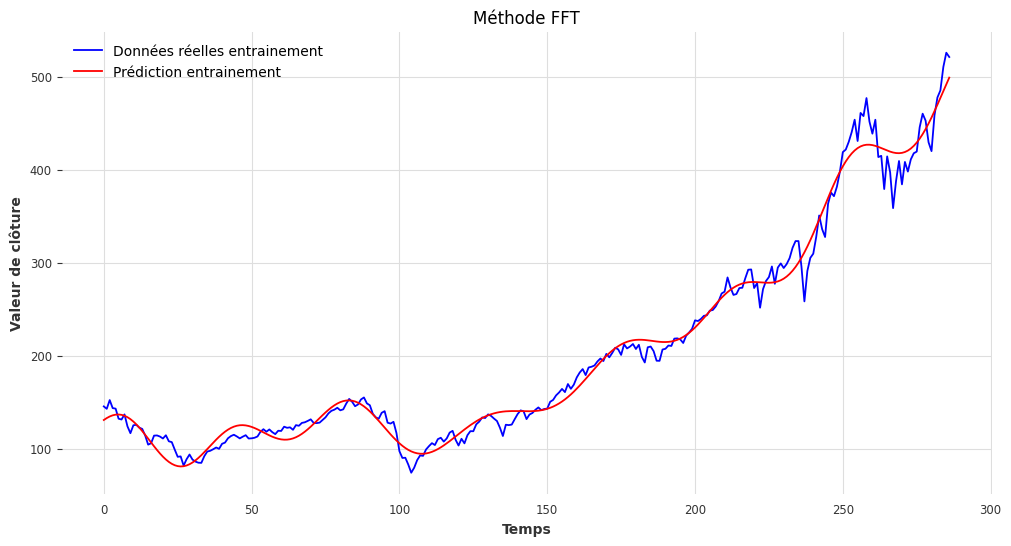

In [70]:
abscisse_train = [i for i in range(len(closing_prices))]

X_pred = [pred_val_train.values()[k] + f_tendance(k) for k in range(len(X_train))]

# Data visualization
plt.figure(figsize=(12, 6))
plt.plot(abscisse_train, closing_prices, label='Données réelles entrainement', color='blue')
plt.plot(abscisse_train, X_pred, label='Prédiction entrainement', color='red')
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.title('Méthode FFT')
plt.legend()
plt.show()

Remarque : Le résultat est déjà beaucoup plus satisfaisant. Les FTT sont des outils très puissants, mathématiquement, les fonctions periodiques cos et sin forment une base. Par conséquent, si on garde un nombre trop important de fréquence, on risque d'observer une composante sinusoïdale qui colle parfaitement la série et donc également le bruit blanc. (Overfitting)

<a id='3'></a>
## 4. Test de Stationnarité : Test de Dickey-Fuller 

**Rappel : Stationnarité du second ordre**

- $E[X_t] = \mu$  : espérance constante
- $V[X_t] = \theta ^2$ : variance constante
- $Cov(X_t, X_t−h) = E(X_t X_{t−h}) − E(X_t)E(X_{t−h}) = \gamma(h)$  : la fonction d'autocovariance est indépendante de t

#### Motivation :

 L'objectif du filtrage de la série ci dessus est de rendre notre série S&P 500 stationnaire dans le but de pouvoir appliquer dessus certains types de modèles que l'on verra dans les paragraphes suivants.


#### **Test de Dickey-Fuller :**

L'objectif de ce test est d'approcher notre série par un modèle du type : $X_t = \mu + \phi X_{t-1} + \epsilon_t$ et d'étudier les hypothèses :
* $H0$ : $\phi = 1$  , la série est une marche aléatoire et donc pas stationnaire 
* $H1$ : $\phi < 1$  , la série est stationnaire (On dit que le processus est un AR)

Remarque : Il s'agit d'une explication très simplifiée, en pratique, les commandes font plutôt appel au "test augmenté de Dickey-Fuller" (ADF) qui consiste à ne pas approcher notre série par un unique modèle mais à plusieurs et tester les deux hypothèses dans chaques cas.

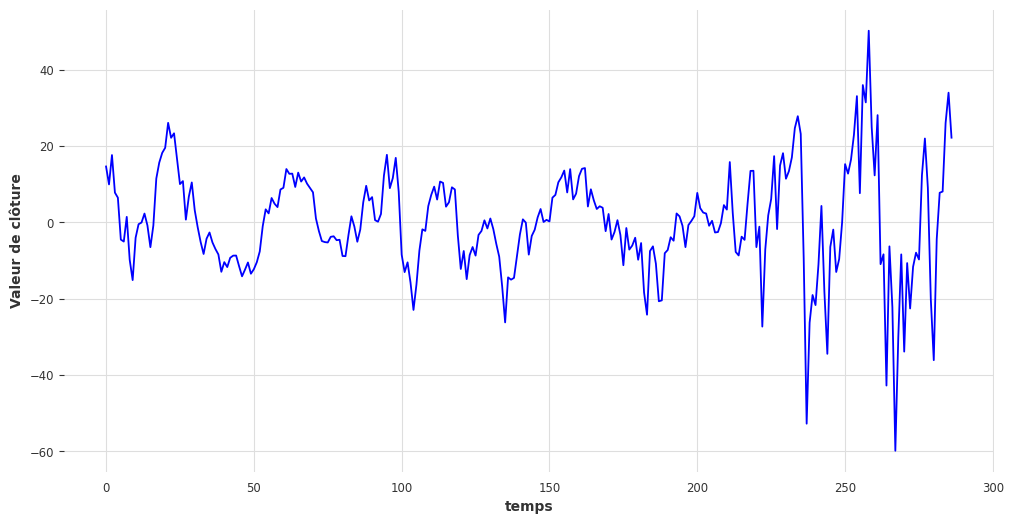

In [71]:
# Représentation de notre série supposée stationnaire 
stationnaire_serie = [closing_prices[k] - X_pred[k] for k in range(len(closing_prices))]

# Data visualisation
abscisse = [i for i in range(len(closing_prices))]

plt.figure(figsize=(12, 6))
plt.plot(abscisse, stationnaire_serie, label = 'Série Stationnaire S&P 500', color = 'blue')
plt.xlabel('temps')
plt.ylabel('Valeur de clôture')
plt.show()

**Observation Graphique :**

Sur le graphique ci-dessus, on peut remarquer que la moyenne peut être considérée comme constante. 
Cependant, en ce qui concerne la variance et l'autocorrélation, il semblerait qu'on observe une hétéroscédasticité flagrante. 
Ce problème pourrait être réglé en pratique en prenant un intervalle de temps plus court.

Nous allons cependant quand même effectuer le Test statistique de Dickey-Fuller pour confirmer notre observation.

In [72]:
from statsmodels.tsa.stattools import adfuller

# Tableau NumPy
stationnaire_serie_array = np.array(stationnaire_serie)

# Test de Dickey-Fuller augmenté
result = adfuller(stationnaire_serie_array)

adf_statistic = result[0]
p_value = result[1]

print("Statistique ADF :", adf_statistic)
print("La p-value est de :", p_value)

Statistique ADF : -5.030106658238542
La p-value est de : 1.9341478295450456e-05


**Conclusion :**

* Le résultat du test renvoie une p-value relativement faible (<0.05), ce qui permet en théorie de rejeter $H0$ et de conclure que notre série est stationnaire. (Contraire à mon intuition)

* De plus, la valeur test ADF (représente le $\phi$ dans ma définition du test) est bien inférieure à 1, ce qui confirme également un résultat stationnaire.

<a id='4'></a>
## 5. Modèles ARMA: (Auto régressive - Moving average)

<a id='4.1'></a>
### 5.1 Description du modèle :

Soit $(X_t)_{t\epsilon Z}$ une suite récurrente aléatoire et $(Z_t)_{t\epsilon Z}$ un bruit blanc.

On dit que $X$ suit un processus **ARMA** si $\exists$ $f$ linéaire et $(p,q)$ tel que :

##### $$X_t = f(X_{t-1},...,X_{t-p},\epsilon_{t-1},...,\epsilon_{t-q})$$

Autrement dit :

##### $$X_t = \mu + \phi_1 X_{t-1} + ... + \phi_p X_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon{t-q}$$

Cas particuliers :
* Lorsque $(p,q)=(1,0)$ : $X_t = \phi X_{t-1} + \epsilon_t$ alors processus markovien
* Lorsque $p=\infty$, alors processus à mémoire longue
* Lorsque $(p,q)=(p,0)$ : modèle AR (autorégressif)
* Lorsque $(p,q)=(0,q)$ : modèle MA (moyenne mobile)

On définit 2 types d'opérateurs :

* Opérateur différentiel : $\Delta X_t = X_t - X_{t-1}$

* Opérateur retard : $L X_t = X_{t-1}$

On peut donc réecrire notre équation comme :

##### $$\Phi(L) X_t = \mu + \Theta(L) \epsilon_t$$ 

Où : $\Phi$ et $\Theta$ sont deux fonctions polynomiales.

Remarque : Les deux polynomes $\Phi$ et $\Theta$ sont importants et donnent des informations sur l'existence et l'unicité de solutions stationnaires avec l'étude des racines. (partie que nous n'aborderons pas dans ce projet)

Si les résidus $\epsilon_t$ obéissent à un bruit blanc, il ne doit pas exister d'autocorélation dans la série, cette propriété se vérifie en pratique grâce à différents tests statistiques :
* Test de Durbin - Watson : test d'autocorélation d'ordre 1
* Etude de la FAC et de la FAP
* Tests du "porte manteau" :
    - Test de Box et Pierce
    - Test de Ljung-Box


<a id='4.2'></a>
### 5.2 Estimation des coefficients du modèle : Méthode Statistique

Paramètres à déterminer :
* Valeurs de $p$ et $q$
* Vecteur $\phi$
* Vecteur $\theta$

#### A. Equations de Yule-Walker : 
 Dans le cas d'un modèle AR (auto-régressif, $q = 0$), les équations de Yule-Walker donne une solution directe pour la valeur du vecteur $\Phi$, la difficulté principale réside dans le calcul de la matrice d'autocovariance.

**Rappel :** 

La fonction d'autocovariance : $\gamma_X{(h)} = COV (X_t, X_{t+h})$ 

##### Equations de Yule-Walker :

$$\begin{pmatrix} \gamma_X{(1)} \\ \vdots \\ \gamma_X{(p)} \end{pmatrix} = 
\begin{bmatrix}
\gamma_X{(0)} & \gamma_X{(1)} & \ldots & \gamma_X{(p-1)} \\
\gamma_X{(1)} & \gamma_X{(0)} & \ldots & \gamma_X{(p-2)} \\
\vdots & \vdots & \ddots & \vdots \\
\gamma_X{(p-1)} & \gamma_X{(p-2)} & \ldots & \gamma_X{(0)}
\end{bmatrix} . \begin{pmatrix} \phi_1 \\ \vdots \\ \phi_p \end{pmatrix}$$

In [73]:
# Fonction autocovariance
def autocovariance(k):
    A = [stationnaire_serie[k + i] for i in range(0, 286 - k)]
    B = [stationnaire_serie[i] for i in range(0, 286 - k)]
    serie_1 = [x[0] for x in A]
    serie_2 = [x[0] for x in B]
    covariance = np.cov(serie_1, serie_2)[0, 1] # [0, 1] car la fonction renvoie la matrice de covariance
    return covariance

def yule_walker(p):
    # Premier vecteur formule 
    vecteur = []
    for k in range(p):
        vecteur.append(autocovariance(k))

    # Matrice autocovariance
    matrice = []
    for k in range(p):
        ligne_i = []
        for j in range(k):
            ligne_i.append(autocovariance(k - j))
        for i in range(p - k):
            ligne_i.append(autocovariance(i))
        matrice.append(ligne_i)

    # Résolution du système d'équations
    phi = np.linalg.solve(matrice, vecteur)
    return phi

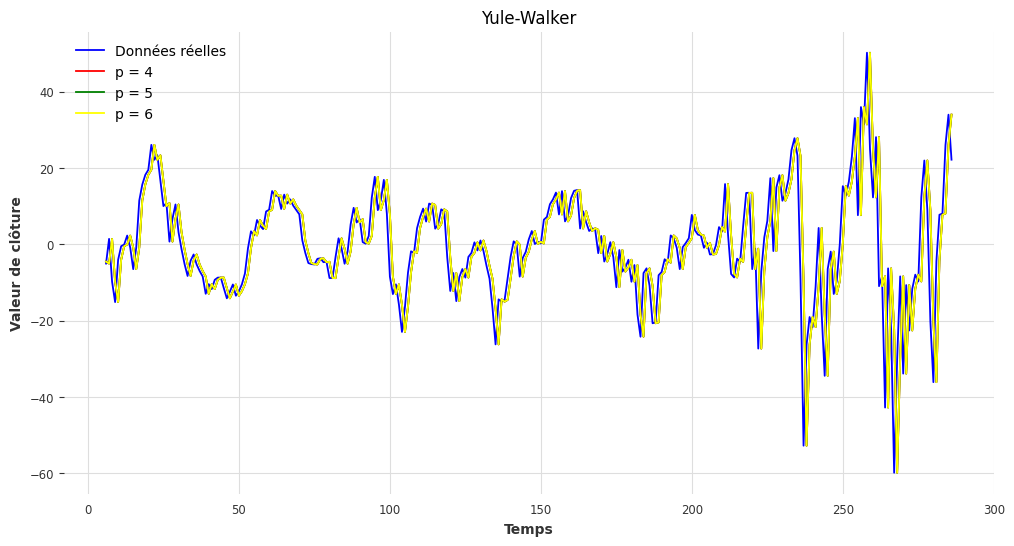

In [74]:
# Visualisation graphique 
# p = 4
serie_p4 = [yule_walker(4)[0] * stationnaire_serie[k - 1] +
            yule_walker(4)[1] * stationnaire_serie[k - 2] +
            yule_walker(4)[2] * stationnaire_serie[k - 3] +
            yule_walker(4)[3] * stationnaire_serie[k - 4]
            for k in range(6, len(stationnaire_serie))]

# p = 5
serie_p5 = [yule_walker(5)[0] * stationnaire_serie[k - 1] +
            yule_walker(5)[1] * stationnaire_serie[k - 2] +
            yule_walker(5)[2] * stationnaire_serie[k - 3] +
            yule_walker(5)[3] * stationnaire_serie[k - 4] +
            yule_walker(5)[4] * stationnaire_serie[k - 5]
            for k in range(6, len(stationnaire_serie))]

# p = 6
serie_p6 = [yule_walker(6)[0] * stationnaire_serie[k - 1] +
            yule_walker(6)[1] * stationnaire_serie[k - 2] +
            yule_walker(6)[2] * stationnaire_serie[k - 3] +
            yule_walker(6)[3] * stationnaire_serie[k - 4] +
            yule_walker(6)[4] * stationnaire_serie[k - 5] +
            yule_walker(6)[5] * stationnaire_serie[k - 6]
            for k in range(6, len(stationnaire_serie))]

abscisse = [i for i in range(6, len(stationnaire_serie))]
serie_originale = [stationnaire_serie[k] for k in range(6, len(stationnaire_serie))]

# Data visualization
plt.figure(figsize=(12, 6))
plt.plot(abscisse, serie_originale, label='Données réelles', color='blue')
plt.plot(abscisse, serie_p4, label='p = 4', color='red')
plt.plot(abscisse, serie_p5, label='p = 5', color='green')
plt.plot(abscisse, serie_p6, label='p = 6', color='yellow')
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.title('Yule-Walker')
plt.legend()
plt.show()

**Remarque :** Ce résultat est un peu décevant mais pas surprenant. Il n'existe presque aucun motif ('pattern') dans les flux de la bourse, donc on se retrouve avec un poids de 1 sur $X_{t-1}$ et un poids presque nul sur les autres valeurs. Le modèle s'ajustent exactement au flux réel avec un décalage d'une période ce qui est équivalent à faire du surajustement sur la partie aléatoire du processus (Bruit blanc), ce qui est très peu pertinent.

#### B. Fonction de vraisemblance conditionelle : Cas d'un modèle autorégressif (on fixe q = 0, $\theta = 0$)

**Remarque :** La fonction de vraisemblance d'un modèle ARMA quelconque fait malheureusement intervenir $\Omega^{-1}$ (où $\Omega_{i,j} = cov(X_i, X_j)$) qui dans la plupart des cas est informatiquement incalculable étant donné que $\Omega$ est une matrice $T \times T$. (Rappel $T$ est le nombre d'observation, ici 286)
Pour cette raison nous allons nous concentrer sur un modèle simplifié autorégressif.

En posant : $\epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon_t}^2)$, $X \sim \mathcal{N}(0, \sigma^2 \Omega)$

On a alors la log-vraisemblance conditionnelle suivante : 

##### $$l(X_1,\ldots,X_T, \phi, \sigma_{\epsilon_t}) = ln[\prod_{t=p+1}^{T}f_{X_t\mid{X_{t-1}, \ldots, X_{t-p}}}(X_t)]$$

$$\Rightarrow l(X_1,\ldots,X_T, \phi, \sigma_{\epsilon_t}) = -\frac{T-p}{2}ln(\sigma_{\epsilon_t}^2) - \frac{1}{2\sigma_{\epsilon_t}^2}\sum_{t=p+1}^{T}(X_t - \sum_{j=1}^{p}\phi_j X_{t-j})^2$$

**Démonstration :**

Loi de $(X_t\mid{X_{t-1}, \ldots, X_{t-p}})_t : \mathcal{N}(\mu_t, \sigma_t^2)$ 

Où :
- $\mu_t = \sum_{j=1}^{p}\phi_j X_{t-j}$
- $\sigma_t^2 = \sigma_{\epsilon_t}^2$

$\Rightarrow L((X_p\mid{X_{p-1}, \ldots, X_{1}}), (X_{p+1}\mid{X_{p}, \ldots, X_{2}}), \ldots, (X_T\mid{X_{T-1}, \ldots, X_{T-p}}), \phi, \sigma_{\epsilon_t})$ 
##### $$= (\frac{1}{2\pi \sigma_{\epsilon_t}^2})^{\frac{T-p}{2}} Exp [-\frac{1}{2} \sum_{t=1}^{T}(\frac{X_t-\mu_t}{\sigma_{\epsilon_t}})^2]$$

On prenant maintenant la log-vraisemblance conditionnelle notée $l(X_1,\ldots,X_T, \phi, \sigma_{\epsilon_t}) = ln[L((X_p\mid{X_{p-1}, \ldots, X_{1}}), (X_{p+1}\mid{X_{p}, \ldots, X_{2}}), \ldots, (X_T\mid{X_{T-1}, \ldots, X_{T-p}}), \phi, \sigma_{\epsilon_t})]$

On obtient : $$l(X_1,\ldots,X_T, \phi, \sigma_{\epsilon_t}) = ln[(\frac{1}{2\pi \sigma_{\epsilon_t}^2})^{\frac{T-p}{2}} Exp [-\frac{1}{2} \sum_{t=1}^{T}(\frac{X_t-\mu_t}{\sigma_{\epsilon_t}})^2]]$$

##### $$\Rightarrow l(X_1,\ldots,X_T, \phi, \sigma_{\epsilon_t}) = -\frac{T-p}{2}ln(\sigma_{\epsilon_t}^2) - \frac{1}{2\sigma_{\epsilon_t}^2}\sum_{t=p+1}^{T}(X_t - \sum_{j=1}^{p}\phi_j X_{t-j})^2$$

In [75]:
# Fonction de log-vraisemblance conditionnelle (On prend le négatif pour minimiser)
def log_vraisemblance(parametres, p, stationnaire_serie):
    phi = parametres[:p]  # Les p premiers paramètres sont pour phi
    sigma = parametres[p]  # Le paramètre à l'indice p + 1 est sigma
    T = len(stationnaire_serie)
    r = 0   # Résultat
    A = 0   # Partie droite formule (avec les sommes)
    for t in range(p + 1, T):
        B = 0
        for j in range(p):
            B += phi[j] * stationnaire_serie[j - t]
        A += (stationnaire_serie[t] - B) ** 2

    r += ((T - p) / 2) * np.log(sigma ** 2)
    r += (1 / (2 * sigma ** 2)) * A
    return r

In [76]:
# Initialisation des valeurs p = 4
p = 4
phi_sigma_initial = np.ones(p + 1)  # Valeurs initiales de phi et de sigma

# Minimisation de la fonction de log-vraisemblance conditionnelle
result = minimize(log_vraisemblance, phi_sigma_initial, args=(p, stationnaire_serie[p:]))

# Récupération des paramètres optimaux
phi_4 = result.x[:p]
sigma_4 = result.x[p]


# Initialisation des valeurs p = 5
p = 5
phi_sigma_initial = np.ones(p + 1)  # Valeurs initiales de phi et de sigma

# Minimisation de la fonction de log-vraisemblance conditionnelle
result = minimize(log_vraisemblance, phi_sigma_initial, args=(p, stationnaire_serie[p:]))

# Récupération des paramètres optimaux
phi_5 = result.x[:p]
sigma_5 = result.x[p]

# Initialisation des valeurs p = 6
p = 6
phi_sigma_initial = np.ones(p + 1)  # Valeurs initiales de phi et de sigma

# Minimisation de la fonction de log-vraisemblance conditionnelle
result = minimize(log_vraisemblance, phi_sigma_initial, args=(p, stationnaire_serie[p:]))

# Récupération des paramètres optimaux
phi_6 = result.x[:p]
sigma_6 = result.x[p]

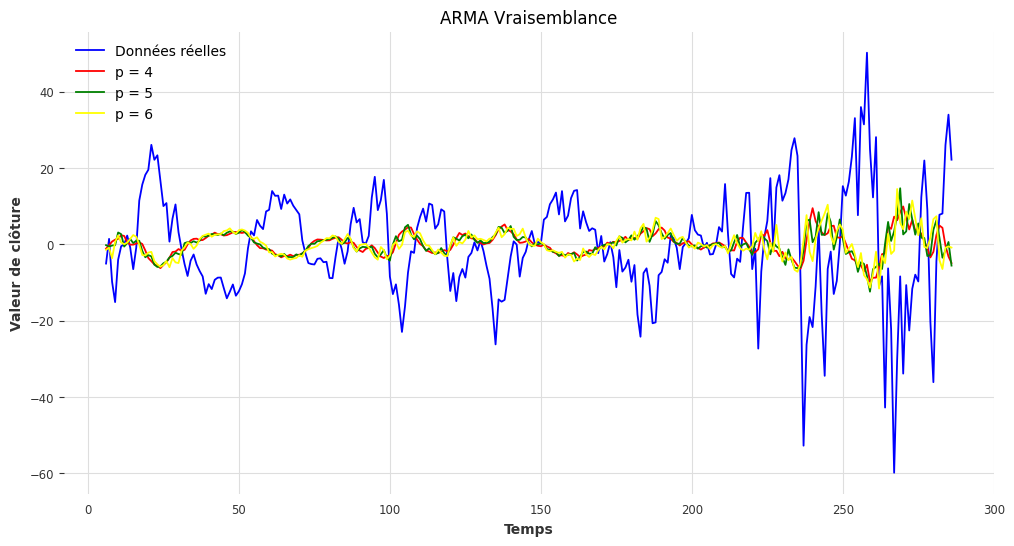

In [77]:
# Visualisation graphique 
# p = 4
serie_p4 = [phi_4[0] * stationnaire_serie[k - 1] +
            phi_4[1] * stationnaire_serie[k - 2] +
            phi_4[2] * stationnaire_serie[k - 3] +
            phi_4[3] * stationnaire_serie[k - 4]
            for k in range(6, len(stationnaire_serie))]

# p = 5
serie_p5 = [phi_5[0] * stationnaire_serie[k - 1] +
            phi_5[1] * stationnaire_serie[k - 2] +
            phi_5[2] * stationnaire_serie[k - 3] +
            phi_5[3] * stationnaire_serie[k - 4] +
            phi_5[4] * stationnaire_serie[k - 5]
            for k in range(6, len(stationnaire_serie))]

# p = 6
serie_p6 = [phi_6[0] * stationnaire_serie[k - 1] +
            phi_6[1] * stationnaire_serie[k - 2] +
            phi_6[2] * stationnaire_serie[k - 3] +
            phi_6[3] * stationnaire_serie[k - 4] +
            phi_6[4] * stationnaire_serie[k - 5] +
            phi_6[5] * stationnaire_serie[k - 6]
            for k in range(6, len(stationnaire_serie))]

abscisse = [i for i in range(6, len(stationnaire_serie))]
serie_originale = [stationnaire_serie[k] for k in range(6, len(stationnaire_serie))]

# Data visualization
plt.figure(figsize=(12, 6))
plt.plot(abscisse, serie_originale, label='Données réelles', color='blue')
plt.plot(abscisse, serie_p4, label='p = 4', color='red')
plt.plot(abscisse, serie_p5, label='p = 5', color='green')
plt.plot(abscisse, serie_p6, label='p = 6', color='yellow')
plt.xlabel('Temps')
plt.ylabel('Valeur de clôture')
plt.title('ARMA Vraisemblance')
plt.legend()
plt.show()

**Rappel :**
Sur ce graphique, nous avons laissé la partie bruit et tracé uniquement la partie déterministe.

**Remarque :**
Ce résultat est beaucoup plus intéressant que le précédent, il permet de nous apercevoir l'importance de la partie autorégressive par rapport à la partie 'moving average'.
On pourrait en conclure que la partie 'déterministe' est presque négligeable (même si on observe de légères variations) par rapport à l'importance du bruit blanc. ($\sigma$ compris entre 10 et 20)

#### C. Critères de Akaïque et Schwarz :

**Critère de Akaïque :** $$AIC = −2 log L + 2(p + q)$$

**Critère de Schwarz :** $$BIC = −2 log L + (p + q) log T$$

Où $L$ représente le maximum de vraisemblance du modèle et $T$ représente le nombre d'observations.

La formule de ces critères est assez intuitive car plus les vecteurs $\phi$ et $\theta$ sont importants, plus le modèle sera précis et la vraisemblance sera élevée.
Le fait de minimiser ces critères permet donc de trouver un juste milieu entre des vecteurs de trop grande dimension, trop lourds à manipuler, et un modèle pas assez précis à cause du manque de paramètres.

In [78]:
# Def fonction BIC
def BIC(p, l):
    T = len(stationnaire_serie)
    return (2 * l + p * np.log(T))

# Liste BIC
Bic = []

for k in range (20, 30):
    # Initialisation des valeurs p = k
    p = k
    phi_sigma_initial = np.ones(p + 1)  # Valeurs initiales de phi et de sigma

    # Minimisation de la fonction de log-vraisemblance conditionnelle
    result = minimize(log_vraisemblance, phi_sigma_initial, args=(p, stationnaire_serie[p:]))   
    valeur_min_log_vraisemblance = result.fun

    Bic.append(BIC(p, valeur_min_log_vraisemblance))

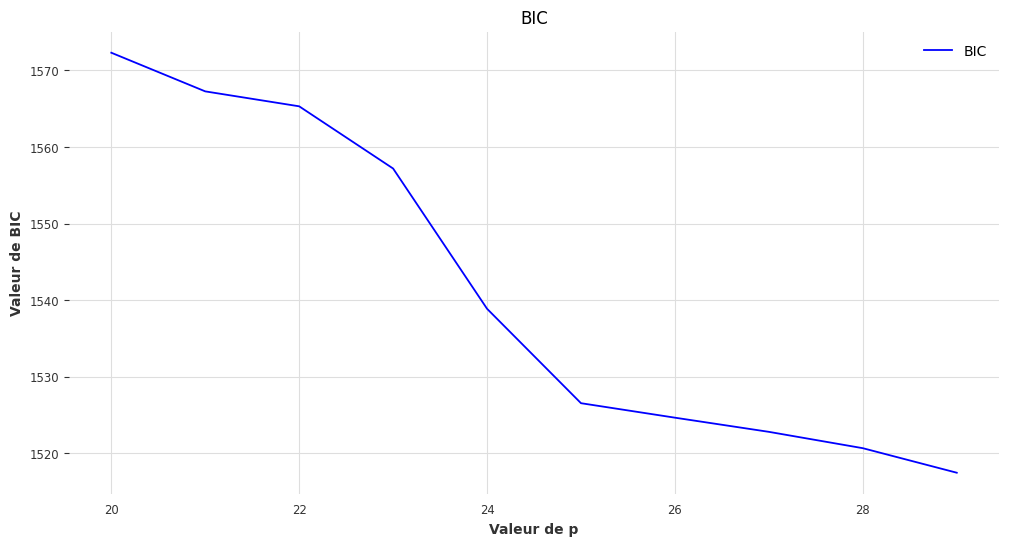

In [79]:
# Data visualisation
abscisse = [i for i in range(20, 30)]

# Data visualization
plt.figure(figsize=(12, 6))
plt.plot(abscisse, Bic, label='BIC', color='blue')
plt.xlabel('Valeur de p')
plt.ylabel('Valeur de BIC')
plt.title('BIC')
plt.legend()
plt.show()

**Remarque :**
Le calcul des $BIC$ est assez long (complexité élevée car calcul du max de vraisemblance), on a quelques difficultés pour trouver le minimum ; cependant, on remarque que passé $p = 25$, la pente commence à s'aplatir.

<a id='5'></a>
## 6. Modèles ARIMA: (Autoregressive integrated moving average)

**Motivation :**
Les processus $ARIMA$ ne sont pas le coeur de ce projet car ils font une généralisation du ARMA pour prendre en compte les séries qui ne sont pas stationnaire.
Dans ce projet nous avons mis en pratique la modélisation de Box et Jenkins (vulgairement : stationnarisation, dessaisonalisation puis estimation) donc nous n'avons pas abordé l'étude directe générale (ARIMA).
Certains algorithme de Machine learning font toutes les étapes du projet en se basant sur le modèle $ARIMA$.

#### Modèle ARIMA :

Pour les modèles $ARIMA$ l'opérateur retard est en général noté $B$ : $B X_t = X_{t-1}$

On dit que $X_t$ est un processus $ARIMA(p,d,q)$ si $(1 - B)^{d}X_t = \Delta ^{d} X$ est un ARMA. ($\Delta ^{d}$ est l'opérateur différence d'ordre d)

Le processus $ARIMA$ va donc s'écrire :

##### $$\Delta ^{d} \Phi (B) X_t = \Theta (B) \epsilon_t$$



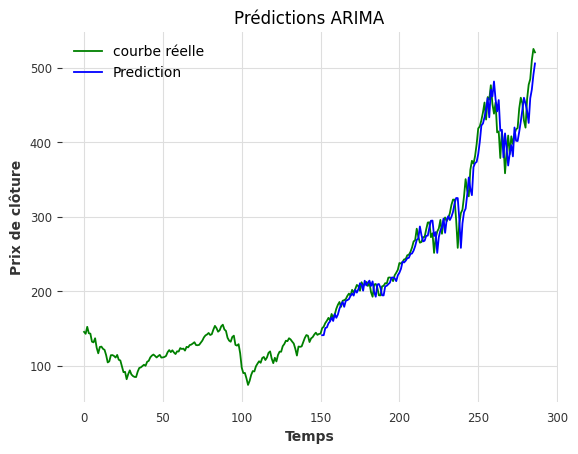

In [86]:
# Importation des bibliothèques
from darts import TimeSeries
from darts.models import AutoARIMA
from sklearn.preprocessing import StandardScaler

# Liste prédiction
pred_a = []

for k in range(150, len(closing_prices) - 1):
    # Le but va être de prédire k+1 à partir des valeurs précedentes
    X_train = closing_prices[:k]

    # Normalisation 
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train.reshape(-1, 1)).flatten()

    # TimeSeries
    series_train = TimeSeries.from_values(X_train_normalized)

    model_arima = AutoARIMA()

    # Entraînement
    model_arima.fit(series_train)

    # Prédiction 
    prediction_arima = model_arima.predict(1)
    
    # Dénormalisation 
    prediction_arima_denormalized = scaler.inverse_transform(prediction_arima.values().reshape(-1, 1)).flatten()
    
    # Ajouter la prédiction à la liste
    pred_a.append(prediction_arima_denormalized[0])


abscisse_pred = [i for i in range (151, len(closing_prices))] 
abscisse = [i for i in range(len(closing_prices))]

# Tracé des données d'entraînement et de leurs prédictions
plt.plot(abscisse, closing_prices, label='courbe réelle', color='green')
plt.plot(abscisse_pred, pred_a, label='Prediction', color='blue')
plt.title('Prédictions ARIMA')
plt.xlabel('Temps')
plt.ylabel('Prix de clôture')
plt.legend()
plt.show()


**Remarque :**
Le module **AUTOARIMA** permet d'ajuster automatiquement les paramètres du modèle contrairement au modèle **ARIMA** classique de DARTS.
Il serai interessant d'étudier l'erreur de ces prédictions et les comparer aux modèles vu précédemment.

<a id='6'></a>
## 7. Forecasting S&P 500:

Avec les données dont nous disposons, il est pratiquement impossible de construire un modèle de prédiction qui pourrait être considéré comme "efficace". Un modèle de prédiction utilisable nécessiterait beaucoup plus de données fondamentales, telles que des données de niveau 2 (indique proportion offre / demande) ou des indicateurs macroéconomiques, par exemple. Néanmoins, pour mener à bien notre projet, nous essaierons quand même d'évaluer la précision de nos prédictions en utilisant un modèle binomial très simple (up/down) utilisé comme "Financial Labeling" qui indique si le prix du mois prochain aura augmenté ou diminué. (Rendement logarithmique positif ou négatif)

<a id='6.1'></a>
### 7.1 Backtest ARIMA de DARTS :

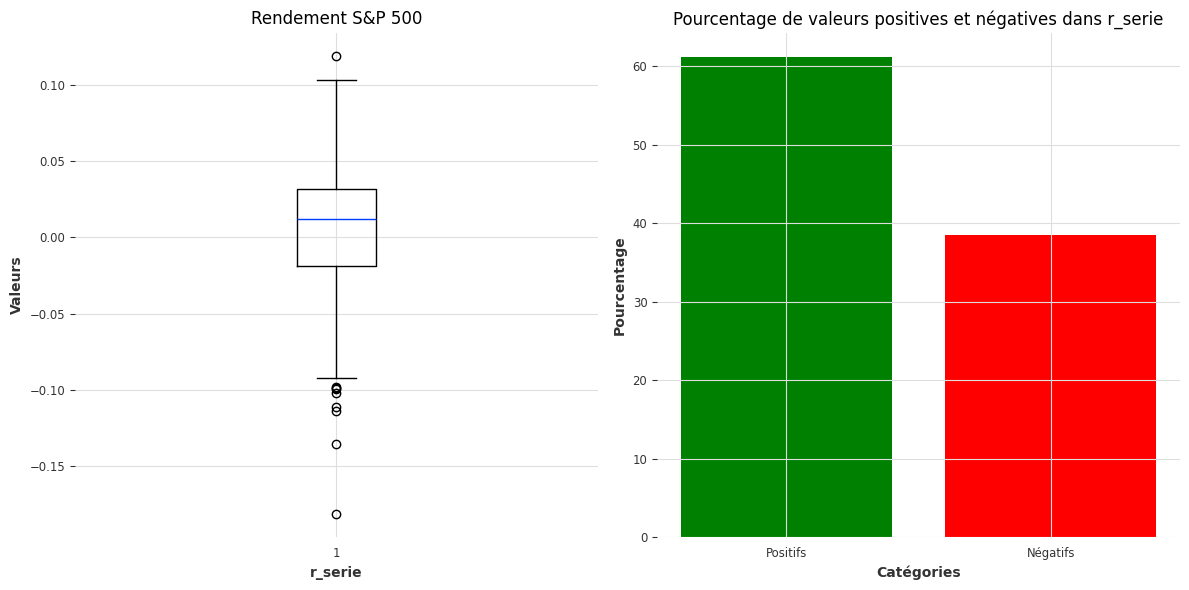

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Liste rendements
r_serie = [np.log(closing_prices[k] / closing_prices[k - 1]) for k in range(1, len(closing_prices))]
r_pred_serie = [np.log(pred[k] / pred[k - 1]) for k in range(1, len(pred))]

# Création des sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot
axs[0].boxplot(r_serie)
axs[0].set_title('Rendement S&P 500')
axs[0].set_xlabel('r_serie')
axs[0].set_ylabel('Valeurs')

# Calcul du pourcentage de valeurs positives et négatives dans r_serie
positifs = sum(1 for valeur in r_serie if valeur > 0)
negatifs = sum(1 for valeur in r_serie if valeur < 0)
total = len(r_serie)

pourcentage_positifs = (positifs / total) * 100
pourcentage_negatifs = (negatifs / total) * 100

# Barplot
categories = ['Positifs', 'Négatifs']
pourcentages = [pourcentage_positifs, pourcentage_negatifs]

axs[1].bar(categories, pourcentages, color=['green', 'red'])
axs[1].set_title('Pourcentage de valeurs positives et négatives dans r_serie')
axs[1].set_xlabel('Catégories')
axs[1].set_ylabel('Pourcentage')

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()


In [82]:
# Filtrer les valeurs positives et négatives dans r_serie
valeurs_positives = [valeur for valeur in r_serie if valeur > 0]
valeurs_negatives = [valeur for valeur in r_serie if valeur < 0]

# Calculer la médiane des valeurs positives et négatives
median_positives = np.median(valeurs_positives)
median_negatives = np.median(valeurs_negatives)

print("Médiane des valeurs positives :", median_positives)
print("Médiane des valeurs négatives :", median_negatives)

# Créer la série binaire
r_binaire = [1 if valeur > 0 else 0 for valeur in r_serie[151 : ]]
r_pred_binaire = [1 if valeur > 0 else 0 for valeur in r_pred_serie]


# Afficher la série r_binaire
print(r_binaire)
print(r_pred_binaire)


Médiane des valeurs positives : 0.02700434119167495
Médiane des valeurs négatives : -0.02548633627757031
[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1]


In [90]:
from sklearn.metrics import accuracy_score

# Calculer l'exactitude de la prédiction
accuracy_arima = accuracy_score(r_binaire, r_pred_binaire)

print("Exactitude de la prédiction :", accuracy_arima)

Exactitude de la prédiction : 0.5703703703703704


<a id='6.2'></a>
### 7.2 Backtest modèle de Box et Jenkins / modèle AR (méthode statistique) :

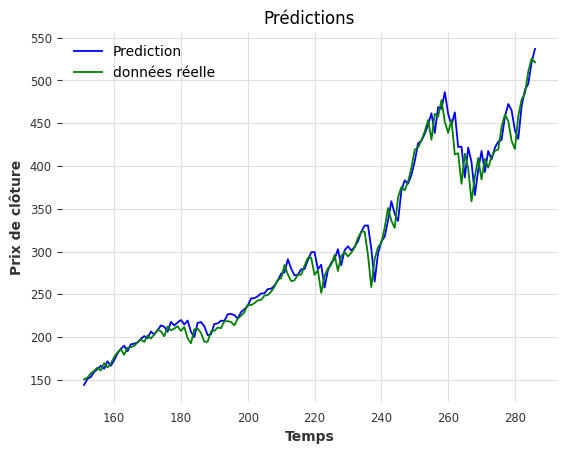

In [85]:
def tendance(d, X):
    # Création de A
    A = np.array([[k**i for i in range(d+1)] for k in range(len(X))])

    # Calcul des coefficients
    B = np.dot(A.T, A)
    B_inverse = np.linalg.inv(B)
    C = np.dot(A.T, X)
    result = np.dot(B_inverse, C)
    
    return result

# Fonction autocovariance
def autocovariance(v, k):
    A = [stationnaire_serie[v + i] for i in range(0, k - v)]
    B = [stationnaire_serie[i] for i in range(0, k - v)]
    serie_1 = [x[0] for x in A]
    serie_2 = [x[0] for x in B]
    covariance = np.cov(serie_1, serie_2)[0, 1] # [0, 1] car la fonction renvoie la matrice de covariance
    return covariance

def yule_walker(p):
    # Premier vecteur formule 
    vecteur = []
    for v in range(p):
        vecteur.append(autocovariance(v, k))

    # Matrice autocovariance
    matrice = []
    for v in range(p):
        ligne_i = []
        for j in range(v):
            ligne_i.append(autocovariance(v - j, k))
        for i in range(p - v):
            ligne_i.append(autocovariance(i, k))
        matrice.append(ligne_i)

    # Résolution du système d'équations
    phi = np.linalg.solve(matrice, vecteur)
    return phi


pred = []

for k in range (151, len(closing_prices)):

    # pred trend
    a = tendance(3, closing_prices[0 : k])

    def f_tendance(t):
        return(a[0] + a[1] * t + a[2] * (t ** 2) + a[3] * (t ** 3))
    
    trend = f_tendance(k+1)
    
    # pred saison : FFT
    data_periodique = [closing_prices[i] - f_tendance(i) for i in range(k)]
    data_periodique = np.array(data_periodique)
    X_train = TimeSeries.from_values(data_periodique)
    model = FFT(nr_freqs_to_keep=10) # On décide de garder 10 fréquences pour éviter overfitting
    model.fit(X_train)
    pred_val_train = model.predict(len(X_train) + 1)
    saison = pred_val_train.values()[k]

    stationnaire_serie = [closing_prices[i] - f_tendance(i) - pred_val_train.values()[i] for i in range (k)]
    # AR : Yule walker p = 6
    serie_p6 = [yule_walker(6)[0] * stationnaire_serie[i - 1] +
                yule_walker(6)[1] * stationnaire_serie[i - 2] +
                yule_walker(6)[2] * stationnaire_serie[i - 3] +
                yule_walker(6)[3] * stationnaire_serie[i - 4] +
                yule_walker(6)[4] * stationnaire_serie[i - 5] +
                yule_walker(6)[5] * stationnaire_serie[i - 6]
                for i in range(6, len(stationnaire_serie) + 1)]
    
    bruit = serie_p6[k - 6]

    prediction = trend + saison + bruit 
    pred.append(prediction)

abscisse_pred = [i for i in range (151, len(closing_prices))] 


# Tracé des données d'entraînement et de leurs prédictions
plt.plot(abscisse_pred, pred, label='Prediction', color='blue')
plt.plot(abscisse_pred, closing_prices[151:], label='données réelle', color='green')
plt.title('Prédictions')
plt.xlabel('Temps')
plt.ylabel('Prix de clôture')
plt.legend()
plt.show()

<a id='6.3'></a>
### 7.3 Comparaison des résultats ARMA / ARIMA :

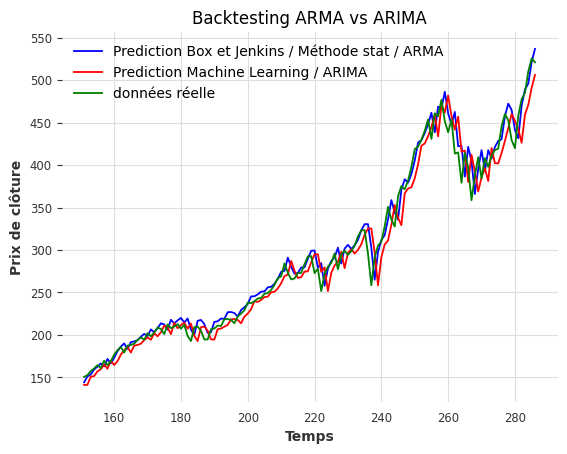

In [88]:
abscisse_pred = [i for i in range (151, len(closing_prices))] 


# Tracé des données d'entraînement et de leurs prédictions
plt.plot(abscisse_pred, pred, label='Prediction Box et Jenkins / Méthode stat / ARMA', color='blue')
plt.plot(abscisse_pred, pred_a, label='Prediction Machine Learning / ARIMA ', color='red')
plt.plot(abscisse_pred, closing_prices[151:], label='données réelle', color='green')
plt.title('Backtesting ARMA vs ARIMA')
plt.xlabel('Temps')
plt.ylabel('Prix de clôture')
plt.legend()
plt.show()

In [91]:
from sklearn.metrics import accuracy_score

# Calculer l'exactitude de la prédiction
accuracy_arma = accuracy_score(r_binaire, r_pred_binaire)

print("Exactitude de la prédiction :", accuracy_arma)

Exactitude de la prédiction : 0.5703703703703704


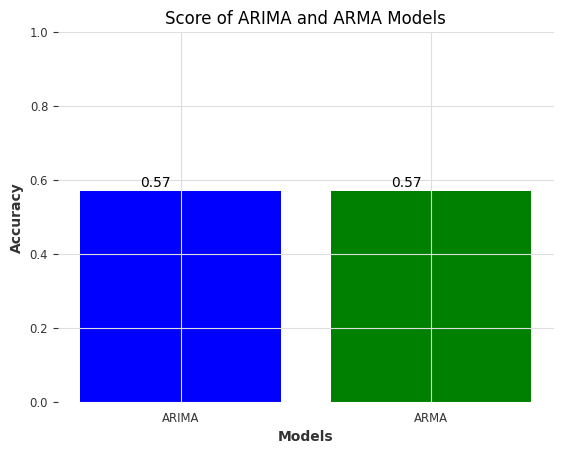

In [94]:
models = ['ARIMA', 'ARMA']
# Valeurs des précisions
accuracies = [accuracy_arima, accuracy_arma]

# Création du diagramme à barres
bars = plt.bar(models, accuracies, color=['blue', 'green'])

# Ajouter les valeurs au-dessus de chaque barre
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{accuracy:.2f}', ha='center', color='black')

# Titres et étiquettes
plt.title('Score of ARIMA and ARMA Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Afficher le diagramme
plt.ylim(0, 1)  # Limiter l'axe y entre 0 et 1
plt.show()

**Le score des prédictions ARMA / ARIMA est plus faible que le pourcentage de rendements positifs, un modèle qui renvoit des rendements positifs à chaque période aura donc un meilleur résultat : la prédiction est très mauvaise.**